# Exploration of SciML
In this notebook we will explore SciML ecosystem and its capabilities. As a study-case we will take the Gray-Scott model (example 02.01) and will try to :
1. Calculate exact solution using the different SciML approaches.
2. Use a neural closure term to learn the parameters using a priori fitting.
We will benchmark some of the key parts and compare the obtained results.

## Helper functions
- Helper function to reshape `ODESolution` to our matrices. Returns an object with dimentions `(x, y,n_samples, t)`

In [1]:
function reshape_ODESolution(ODE_sol, grid)
    u = reshape(ODE_sol[1:(grid.N), :, :], grid.nx, grid.ny, size(ODE_sol, 2), :)
    v = reshape(ODE_sol[(grid_GS.N + 1):end, :, :], grid.nx, grid.ny, size(ODE_sol, 2), :)
    return u, v
end

reshape_ODESolution (generic function with 1 method)

- Helper function to plot a Gray-Scott heatmap

In [2]:
function GS_heatmap(data; title = "", color = :reds)
    return heatmap(data,
        axis = false,
        cbar = false,
        aspect_ratio = 1,
        color = color,
        title = title,
        framestyle = :none)
end

GS_heatmap (generic function with 1 method)

## Definition of the problem
As a reminder, the GS model is defined from
$\begin{equation}\begin{cases} \frac{du}{dt} = D_u \Delta u - uv^2 + f(1-u)  \equiv F_u(u,v) \\ \frac{dv}{dt} = D_v \Delta v + uv^2 - (f+k)v  \equiv G_v(u,v)\end{cases} \end{equation}$
where $u(x,y,t):\mathbb{R}^2\times \mathbb{R}\rightarrow \mathbb{R}$ is the concentration of species 1, while $v(x,y,t)$ is the concentration of species two. This model reproduce the effect of the two species diffusing in their environment, and reacting together.
This effect is captured by the ratios between $D_u$ and $D_v$ (diffusion coefficients) and $f$ and $k$ (reaction rates).
Here we define elements common to all cases: a 2D grid, initial conditions, forces $F_u$ and $G_v$.

Definition of the grid

In [3]:
import CoupledNODE: Grid, grid_to_linear, linear_to_grid
dx = dy = 1.0
nx = ny = 64
grid_GS = Grid(dim = 2, dx = dx, nx = nx, dy = dy, ny = ny)

Grid(2, 1.0, 1.0, 0.0f0, 64, 64, 0, 4096, [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0  …  54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0], [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0  …  54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0], nothing)

Definition of the initial condition as a random perturbation over a constant background to add variety.
Notice that this initial conditions are different from those of the previous example.

In [4]:
import Random
rng = Random.seed!(1234);
function initial_condition(grid_u, grid_v, U₀, V₀, ε_u, ε_v; nsimulations = 1)
    u_init = U₀ .+ ε_u .* Random.randn(grid_u.nx, grid_u.ny, nsimulations)
    v_init = V₀ .+ ε_v .* Random.randn(grid_v.nx, grid_v.ny, nsimulations)
    return u_init, v_init
end
U₀ = 0.5    # initial concentration of u
V₀ = 0.25   # initial concentration of v
ε_u = 0.05  # magnitude of the perturbation on u
ε_v = 0.1   # magnitude of the perturbation on v
u_initial, v_initial = initial_condition(
    grid_GS, grid_GS, U₀, V₀, ε_u, ε_v, nsimulations = 20);

We define the initial condition as a flattened concatenated array

In [5]:
uv0 = vcat(reshape(u_initial, grid_GS.N, :), reshape(v_initial, grid_GS.N, :));

These are the GS parameters (also used in example 02.01)

In [6]:
D_u = 0.16
D_v = 0.08
f = 0.055
k = 0.062;

Exact right hand sides (functions) of the GS model

In [7]:
import CoupledNODE: Laplacian
F_u(u, v) = D_u * Laplacian(u, grid_GS.dx, grid_GS.dy) .- u .* v .^ 2 .+ f .* (1.0 .- u)
G_v(u, v) = D_v * Laplacian(v, grid_GS.dx, grid_GS.dy) .+ u .* v .^ 2 .- (f + k) .* v

G_v (generic function with 1 method)

### Burnout runs
We're going to perform some burnout runs in order to get to an initial state common to all cases.
Definition of the CNODE that is not closed (i.e. no neural closure term).

In [8]:
import Lux
import CoupledNODE: create_f_CNODE
f_burnout = create_f_CNODE((F_u, G_v), (grid_GS, grid_GS); is_closed = false);
θ_0, st_0 = Lux.setup(rng, f_burnout); # placeholder parameters (not meaningful)

import DifferentialEquations: Tsit5
solver_algo = Tsit5(); # defined for all cases
import DiffEqFlux: NeuralODE
trange_burn = (0.0, 1.0)
dt, saveat = (1e-2, 1)
burnout_CNODE = NeuralODE(f_burnout,
    trange_burn,
    solver_algo,
    adaptive = false,
    dt = dt,
    saveat = saveat);
burnout_CNODE_solution = Array(burnout_CNODE(uv0, θ_0, st_0)[1]);

We will use the last state of the burnout as the initial condition for the next exploration

In [9]:
uv0 = burnout_CNODE_solution[:, :, end];

We define de time span, dt and saveat cused to generate the solutions that we want to compare.

In [10]:
trange = (0.0, 2000.0);
dt, saveat = (1 / (4 * max(D_u, D_v)), 10);

## 1. Exact solution
### a. [NeuralODE](https://docs.sciml.ai/DiffEqFlux/stable/examples/neural_ode/)
We are going to use `f_burnout` that is a right hand side that is not closed with a neural network.

In [11]:
neural_ODE_problem = NeuralODE(
    f_burnout, trange, solver_algo, adaptive = false, dt = dt, saveat = saveat);
@time neural_ODE_exact_sol = Array(neural_ODE_problem(uv0, θ_0, st_0)[1]);

 42.520771 seconds (2.18 M allocations: 298.835 GiB, 32.12% gc time)


`41.340940 seconds (2.18 M allocations: 298.835 GiB, 31.85% gc time)`

In [12]:
u_neural_ODE, v_neural_ODE = reshape_ODESolution(neural_ODE_exact_sol, grid_GS);

### b. [ODEProblem](https://docs.sciml.ai/DiffEqDocs/stable/types/ode_types/#ode_prob)
In this case, we need to create a wrapper around our force that would have the signature expected by `ODEProblem`.
Options are:
- `f(du,u,p,t)`: in-place
- `f(u,p,t)`: returning `du`, out of place

In [13]:
function rhs_ode_problem(u, p, t)
    f_burnout(u, θ_0, st_0)[1]
end

rhs_ode_problem (generic function with 1 method)

then define the problem and solve it:

In [14]:
using DifferentialEquations: ODEProblem, solve
ODE_problem = ODEProblem(rhs_ode_problem, uv0, trange);
@time ODE_exact_sol = solve(
    ODE_problem, solver_algo, adaptive = false, dt = dt, saveat = saveat);

 36.815600 seconds (3.03 M allocations: 298.402 GiB, 13.16% gc time, 0.96% compilation time)


`39.702393 seconds (3.03 M allocations: 298.401 GiB, 14.79% gc time, 0.84% compilation time)`

In [15]:
u_ODE, v_ODE = reshape_ODESolution(Array(ODE_exact_sol), grid_GS);

We can also define our forces in place (i.e. they modify `du` and `dv`) therefore the `!` in the function signature

In [16]:
function rhs_ode_problem_in!(du, u, p, t)
    #u has dimensions (cat(flattened(u,v)), nsamples)
    u_gs = reshape(u[1:(grid_GS.N), :], grid_GS.nx, grid_GS.ny, size(u)[end])
    v_gs = reshape(u[(grid_GS.N + 1):end, :], grid_GS.nx, grid_GS.ny, size(u)[end])
    du_gs = F_u(u_gs, v_gs)
    dv_gs = G_v(u_gs, v_gs)
    #We need to use .= to mutate du otherwise it will create a copy.
    du .= vcat(grid_to_linear(grid_GS, du_gs), grid_to_linear(grid_GS, dv_gs))
end

rhs_ode_problem_in! (generic function with 1 method)

out of place: return `du`, also see that there is no `!` in the function signature

In [17]:
function rhs_ode_problem_out(u, p, t)
    #u has dimensions (cat(flattened(u,v)), nsamples)
    u_gs = reshape(u[1:(grid_GS.N), :], grid_GS.nx, grid_GS.ny, size(u)[end])
    v_gs = reshape(u[(grid_GS.N + 1):end, :], grid_GS.nx, grid_GS.ny, size(u)[end])
    du_gs = F_u(u_gs, v_gs)
    dv_gs = G_v(u_gs, v_gs)
    return vcat(grid_to_linear(grid_GS, du_gs), grid_to_linear(grid_GS, dv_gs))
end

rhs_ode_problem_out (generic function with 1 method)

and let's see if there is any difference in performance

In [18]:
ODE_problem_in = ODEProblem(rhs_ode_problem_in!, uv0, trange);
@time ODE_exact_sol_in = solve(ODE_problem_in, solver_algo, adaptive = false, dt = dt, saveat = saveat);

 30.574076 seconds (3.94 M allocations: 222.298 GiB, 10.38% gc time, 2.48% compilation time)


`33.438104 seconds (3.94 M allocations: 222.298 GiB, 11.76% gc time, 2.21% compilation time)`

In [19]:
ODE_problem_out = ODEProblem(rhs_ode_problem_out, uv0, trange);
@time ODE_exact_sol_out = solve(
    ODE_problem_out, solver_algo, adaptive = false, dt = dt, saveat = saveat);

 37.271104 seconds (3.06 M allocations: 298.403 GiB, 11.49% gc time, 0.95% compilation time)


`38.377476 seconds (3.05 M allocations: 298.403 GiB, 11.64% gc time, 0.87% compilation time)`

### c. ODEProblem for PDEs following https://docs.sciml.ai/Overview/stable/showcase/gpu_spde/
In this approach `u` is a matrix in which the first dimension correspont to the variable ($u$ or $v$).

In place definition. Pay attenton to `!` and `.=`.

In [20]:
function rhs_pde!(du, u, p, t)
    u_gs = @view u[1, :, :, :]
    v_gs = @view u[2, :, :, :]
    du_gs = @view du[1, :, :, :]
    dv_gs = @view du[2, :, :, :]
    du_gs .= F_u(u_gs, v_gs)
    dv_gs .= G_v(u_gs, v_gs)
end

rhs_pde! (generic function with 1 method)

Out of place definition (not working either)

In [21]:
function rhs_pde(u, p, t)
    u_gs = @view u[1, :, :, :]
    v_gs = @view u[2, :, :, :]
    du_gs = F_u(u_gs, v_gs)
    dv_gs = G_v(u_gs, v_gs)
    return permutedims(cat(du_gs, dv_gs, dims = 4), [4, 1, 2, 3])
end

u0 = permutedims(cat(u_initial, v_initial, dims = 4), [4, 1, 2, 3]); # 2x64x64x20 n_vars x nx x ny x n_samples
PDE_problem = ODEProblem(rhs_pde!, u0, trange)
@time PDE_exact_sol = solve(
    PDE_problem, solver_algo, adaptive = false, dt = dt, saveat = saveat);

 30.204434 seconds (9.65 M allocations: 203.936 GiB, 9.73% gc time, 6.43% compilation time)


With out-of-place definition:
- 1st time: `61.979926 seconds (3.93 M allocations: 298.467 GiB, 36.20% gc time, 1.46% compilation time)`
- 2nd time: `59.904910 seconds (2.30 M allocations: 298.362 GiB, 35.24% gc time)`
With in-place definition:
- 1st time: `29.790686 seconds (9.65 M allocations: 203.936 GiB, 9.15% gc time, 6.55% compilation time)`
- 2nd time: `26.900031 seconds (1.90 M allocations: 203.431 GiB, 12.54% gc time)`

In [22]:
u_PDE = Array(PDE_exact_sol)[1, :, :, :, :];
v_PDE = Array(PDE_exact_sol)[2, :, :, :, :];

### Comparison
#### Results
Let's check if there are any differences between the solutions:

In [23]:
any(u_ODE - u_neural_ODE .!= 0.0)
any(v_ODE - v_neural_ODE .!= 0.0)
any(u_PDE - u_neural_ODE .!= 0.0)
any(v_PDE - v_neural_ODE .!= 0.0)

true

We see that:
- _ODEProblem vs NeuralODE_: all values are zero, the solutions are identical!
- _PDEProblem vs NeuralODE_: there are differences between the solutions. (_PDEProblem_ is ODEProblem formulated as a PDE)

Also let's see if there is any difference between the in-place and out-of-place definitions

In [24]:
any(ODE_exact_sol_in .!= ODE_exact_sol)
any(ODE_exact_sol_out .!= ODE_exact_sol)
any(ODE_exact_sol_in .!= ODE_exact_sol_out)

true

We see that the spolutions of out-of-place and defining the right hand side as the CNODE are identical. However, defining the right hand side as an in-place function gives different results.

#### Plots

┌ Info: Saved animation to /var/folders/ls/dj0bf91x7715kphjd6dghv0w0000gn/T/jl_ZST0fstuRi.gif
└ @ Plots /Users/luisaorozco/.julia/packages/Plots/ju9dp/src/animation.jl:156


Plots.AnimatedGif("/var/folders/ls/dj0bf91x7715kphjd6dghv0w0000gn/T/jl_ZST0fstuRi.gif")
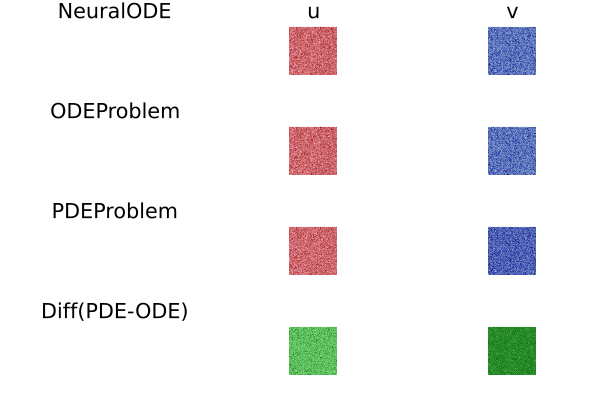

In [25]:
using Plots, Plots.PlotMeasures
anim = Animation()
fig = plot(layout = (4, 3))
@gif for i in 1:1:size(u_ODE, 4)
    # First row: set of parameters 1
    p1 = GS_heatmap(u_neural_ODE[:, :, 1, i], title = "u")
    p2 = GS_heatmap(v_neural_ODE[:, :, 1, i], title = "v", color = :blues)
    p3 = GS_heatmap(u_ODE[:, :, 1, i])
    p4 = GS_heatmap(v_ODE[:, :, 1, i], color = :blues)
    p5 = GS_heatmap(u_PDE[:, :, 1, i])
    p6 = GS_heatmap(v_PDE[:, :, 1, i], color = :blues)
    p7 = GS_heatmap(u_PDE[:, :, 1, i] - u_neural_ODE[:, :, 1, i], color = :greens)
    p8 = GS_heatmap(v_PDE[:, :, 1, i] - v_ODE[:, :, 1, i], color = :greens)

    #Create titles as separate plots
    t1 = plot(title = "NeuralODE", framestyle = :none)
    t2 = plot(title = "ODEProblem", framestyle = :none)
    t3 = plot(title = "PDEProblem", framestyle = :none)
    t4 = plot(title = "Diff(PDE-ODE)", framestyle = :none)

    fig = plot(t1, p1, p2, t2, p3, p4, t3, p5, p6, t4, p7, p8,
        layout = (4, 3),
        margin = 0mm)
    frame(anim, fig)
end

#### Time and memory usage
We can see that the `NeuralODE` and `ODEProblem` have similar performance, while the `PDEProblem` is slower.
All of the implementations presented here have a similar (high) number of allocations and memory usage.

##### In-place and out-of-place right hand side definitions
We see aspeed up in time but also more allocations.

**Next steps:** Try out with a different (better written) implementation of the forces.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*